## Initialising model and libraries

In [1]:
import sys

sys.path.append('../')
from fit.datamodules.super_res import MNIST_SResFITDM, CelebA_SResFITDM#MNIST_SResFITDM_Large,Omniglot
from fit.utils.tomo_utils import get_polar_rfft_coords_2D

import time
from fit.modules.SResTransformerModule import SResTransformerModule

from matplotlib import pyplot as plt
from matplotlib import gridspec
from fit.utils.PSNR import RangeInvariantPsnr as PSNR
# from fit.utils.utils import PSNR
import torch
import numpy as np
from pytorch_lightning import seed_everything

import seaborn as sns
import matplotlib.pyplot as plt
from fit.utils.utils import denormalize

# trained_model_path = '/home/aman.kukde/Projects/Old_FIT/models/CelebA/mamba/sum/Mamba_CelebA_wp_10000_sum_L_8_H_8_s_10_subset_False_Contd._29-04_LR_Reset03-05_10-55-04/epoch=1573-step=983750.ckpt'
trained_model_path = '/home/aman.kukde/Projects/Old_FIT/models/CelebA/fast/sum/Fast_CelebA_wp_1000_sum_L_8_H_8_s_10_subset_False_Contd._08_04-18_18_18_29-04_18-32-39/epoch=1461-step=2130000.ckpt'
# trained_model_path = '/group/jug/Aman/Trained_Models/CelebA/mamba/sum/Mamba_CelebA_wp_1000_sum_L_8_H_8_s_10_subset_False_SectorEncoder_NSec1_01-06_15-57-43/epoch=449-step=281250.ckpt'
# trained_model_path = '/group/jug/Aman/Trained_Models/MNIST/mamba/sum/Mamba_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_31-05_14-29-16/epoch=992-step=853980.ckpt'
# trained_model_path = '/group/jug/Aman/Trained_Models/MNIST/fast/sum/Fast_MNIST_wp_1000_sum_L_8_H_8_s_10_subset_False_30-05_11-52-23/epoch=1004-step=864300.ckpt'
dataset = trained_model_path.split('/')[-5]
model_type = trained_model_path.split('/')[-4]
loss = trained_model_path.split('/')[-3]

seed_everything(22122020)
# dataset = "omniglot"
if dataset == "MNIST":
    dm = MNIST_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=32, subset_flag=False)
if dataset == "MNIST_large":
    dm = MNIST_SResFITDM_Large(root_dir="./datamodules/data/",
                            batch_size=2, subset_flag=False)
if dataset == "CelebA":
    dm = CelebA_SResFITDM(root_dir="./datamodules/data/",
                            batch_size=8, subset_flag=False)
if dataset == "omniglot":
    dm = Omniglot(root_dir="./datamodules/data/",batch_size=8, subset_flag=False)

dm.prepare_data()
dm.setup()
r, phi, flatten_order, order = get_polar_rfft_coords_2D(img_shape=dm.gt_shape)
n_heads = 8
d_query = 32
model = SResTransformerModule(img_shape=dm.gt_shape,
                              coords=(r, phi),
                              dst_flatten_order=flatten_order,
                              dst_order=order,
                              loss=loss,
                              lr=0.0001, weight_decay=0.01, n_layers=8,
                              n_heads=n_heads, d_query=d_query,num_shells = 6,
                              model_type = model_type)


weights = torch.load(trained_model_path)['state_dict']
model.load_state_dict(weights, strict=True);print('Model Loaded')
model.cuda()
model.eval()


/localscratch/miniforge3/envs/SSM_LS/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Seed set to 22122020


Model Loaded


SResTransformerModule(
  (sres): SResTransformer(
    (fourier_coefficient_embedding): Linear(in_features=2, out_features=128, bias=True)
    (pos_embedding): PositionalEncoding2D(
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (attention): AttentionLayer(
            (inner_attention): FullAttention(
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (query_projection): Linear(in_features=256, out_features=256, bias=True)
            (key_projection): Linear(in_features=256, out_features=256, bias=True)
            (value_projection): Linear(in_features=256, out_features=256, bias=True)
            (out_projection): Linear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=1024, bias=True)
          (linear2): Linear(in_features=1024, out_features=256, bias=True)
       

torch.Size([2016, 2])


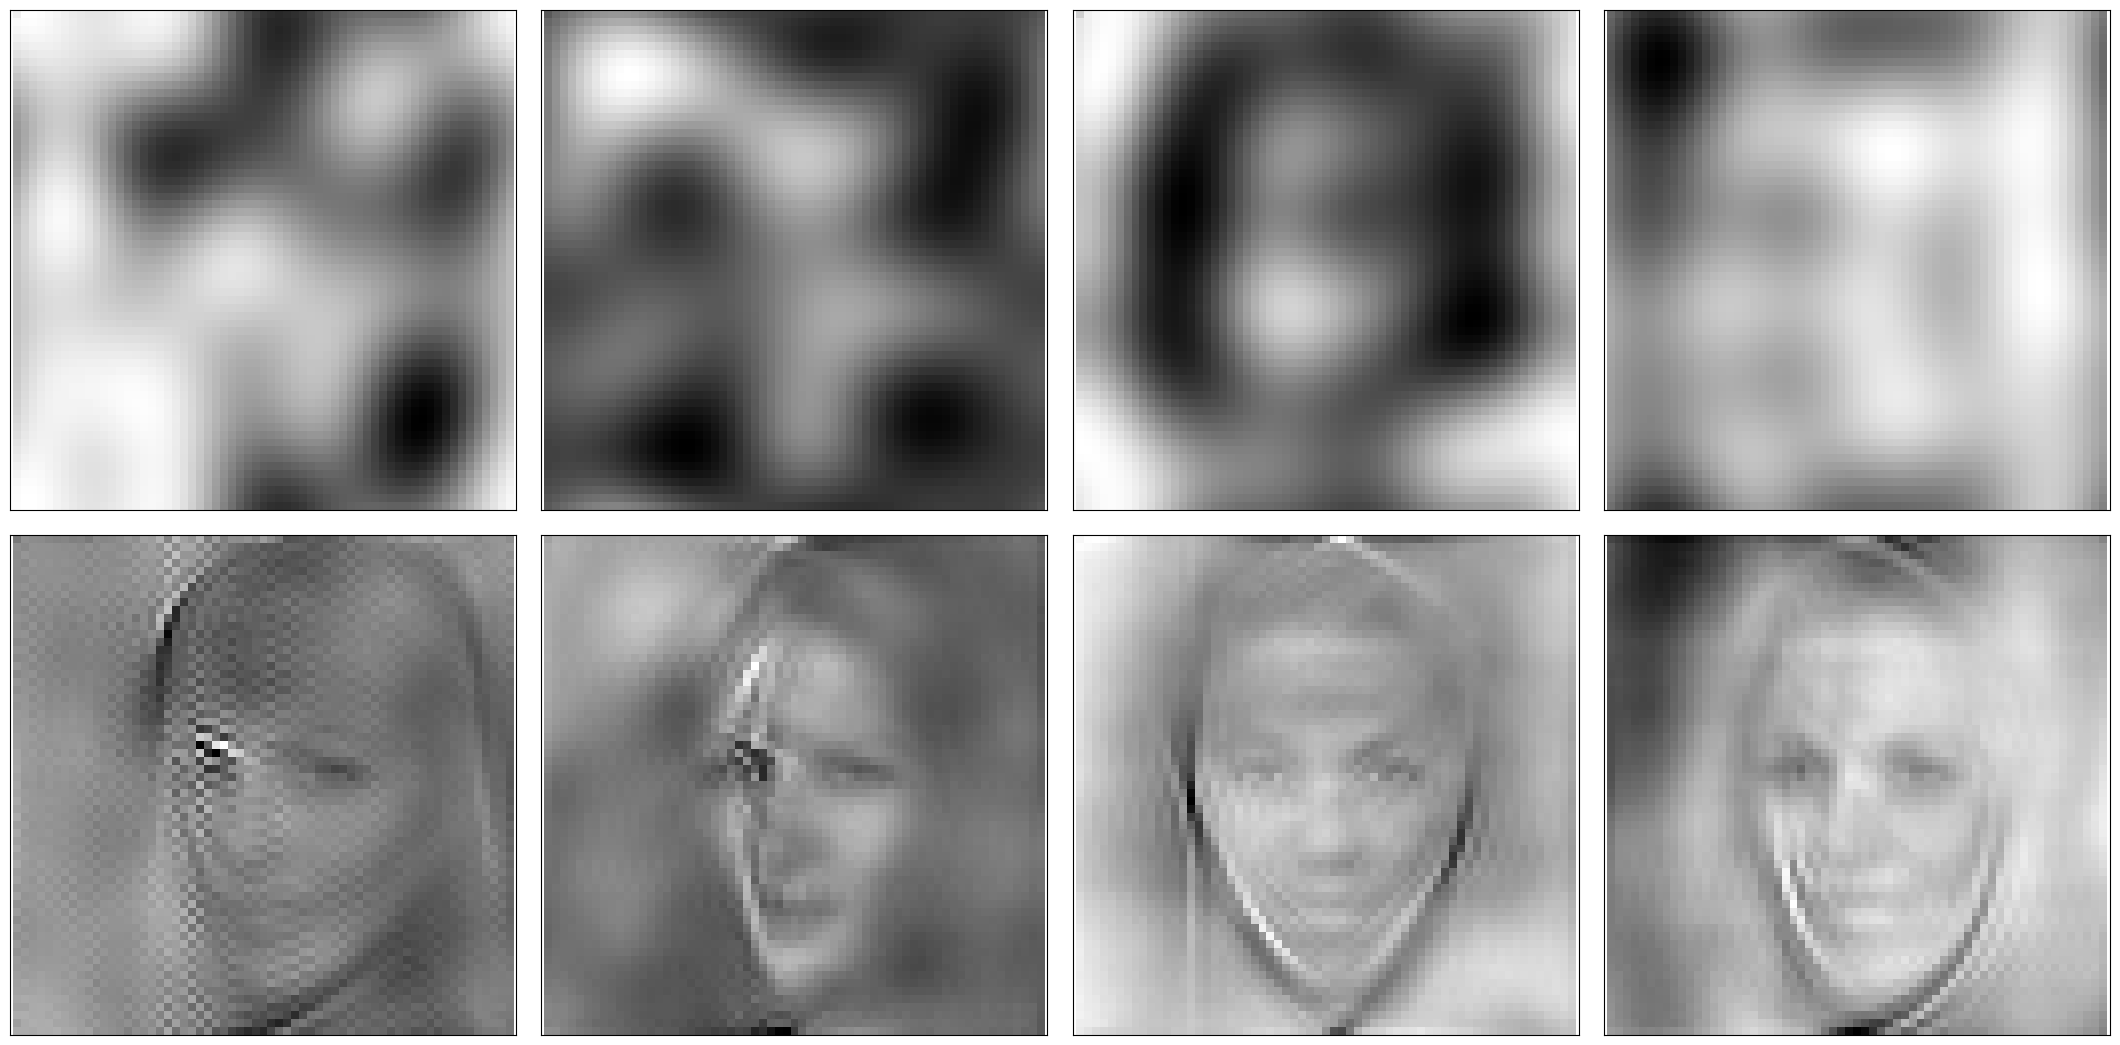

torch.Size([2016, 2])


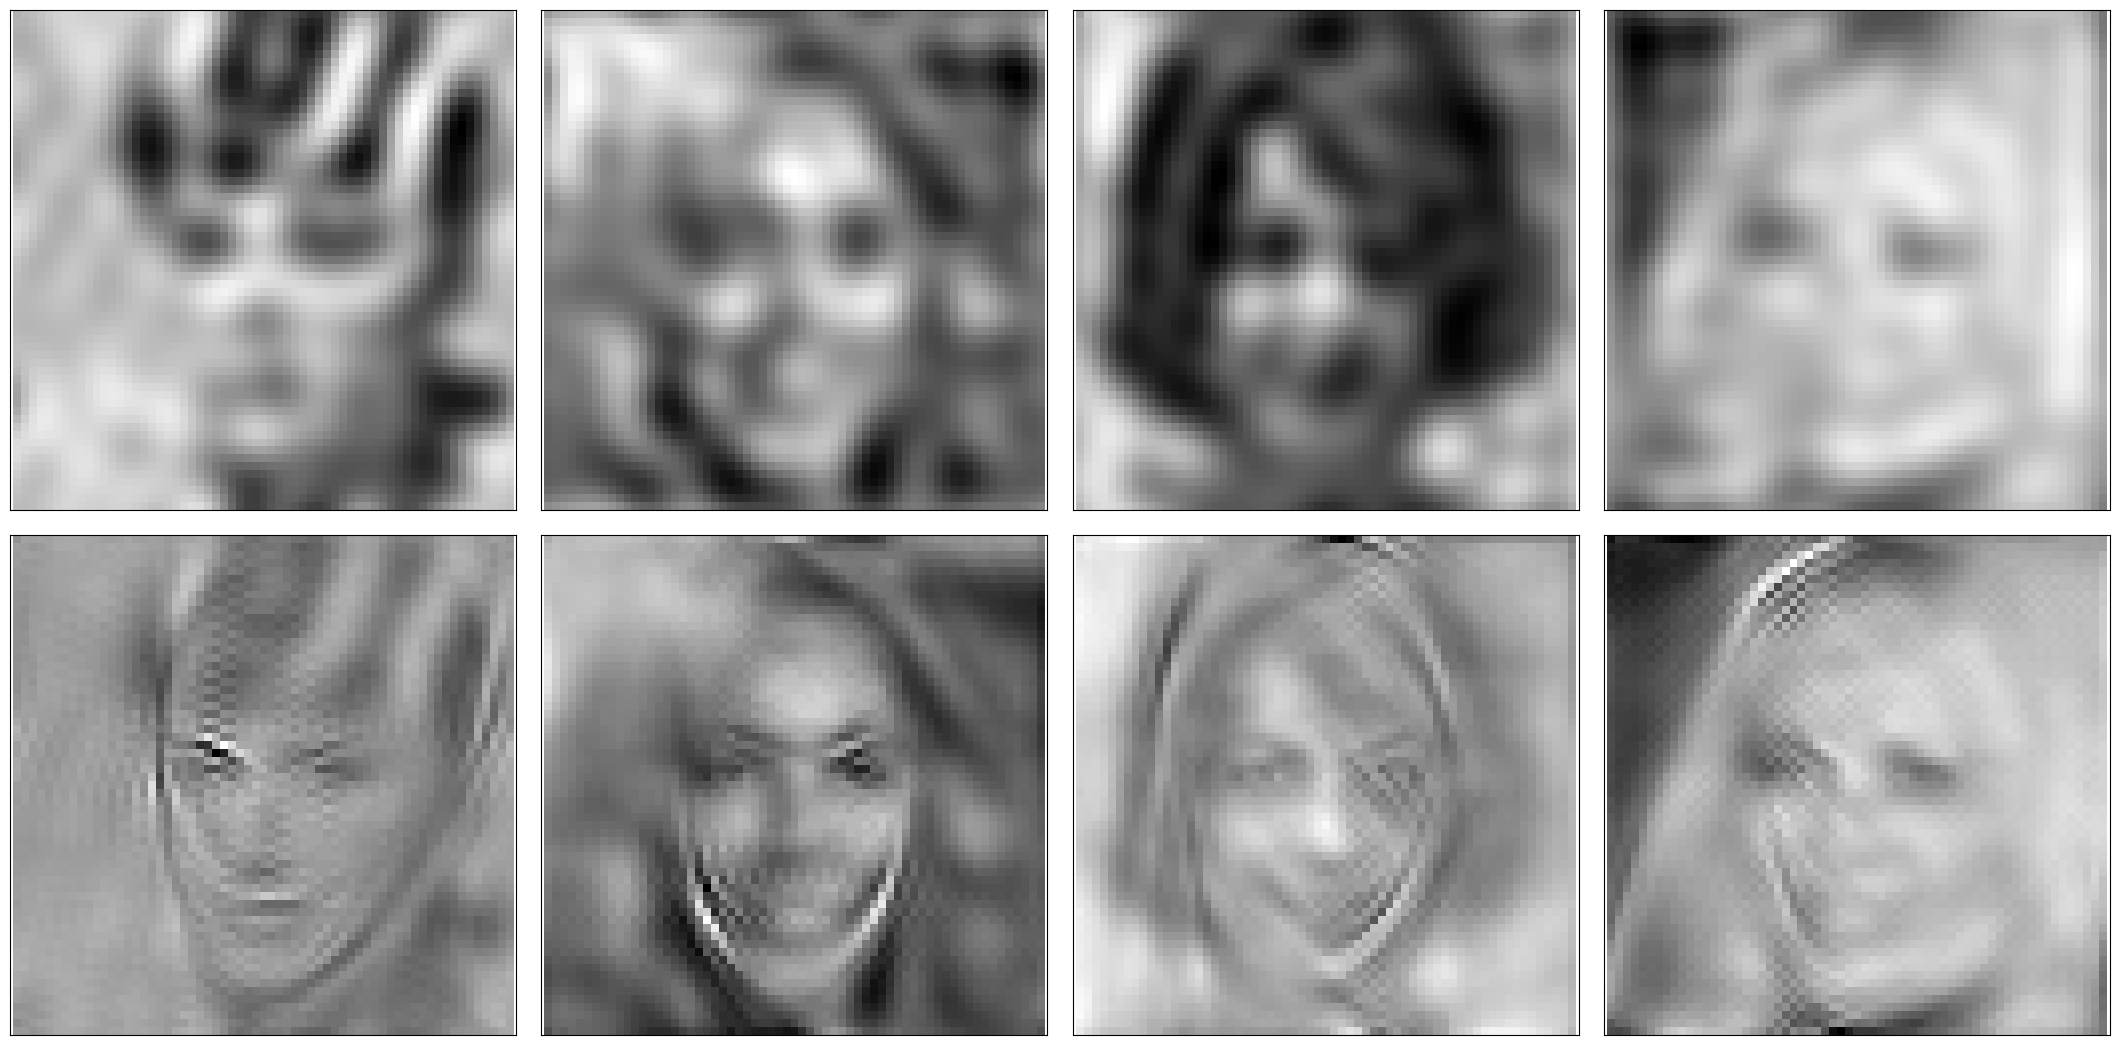

torch.Size([2016, 2])


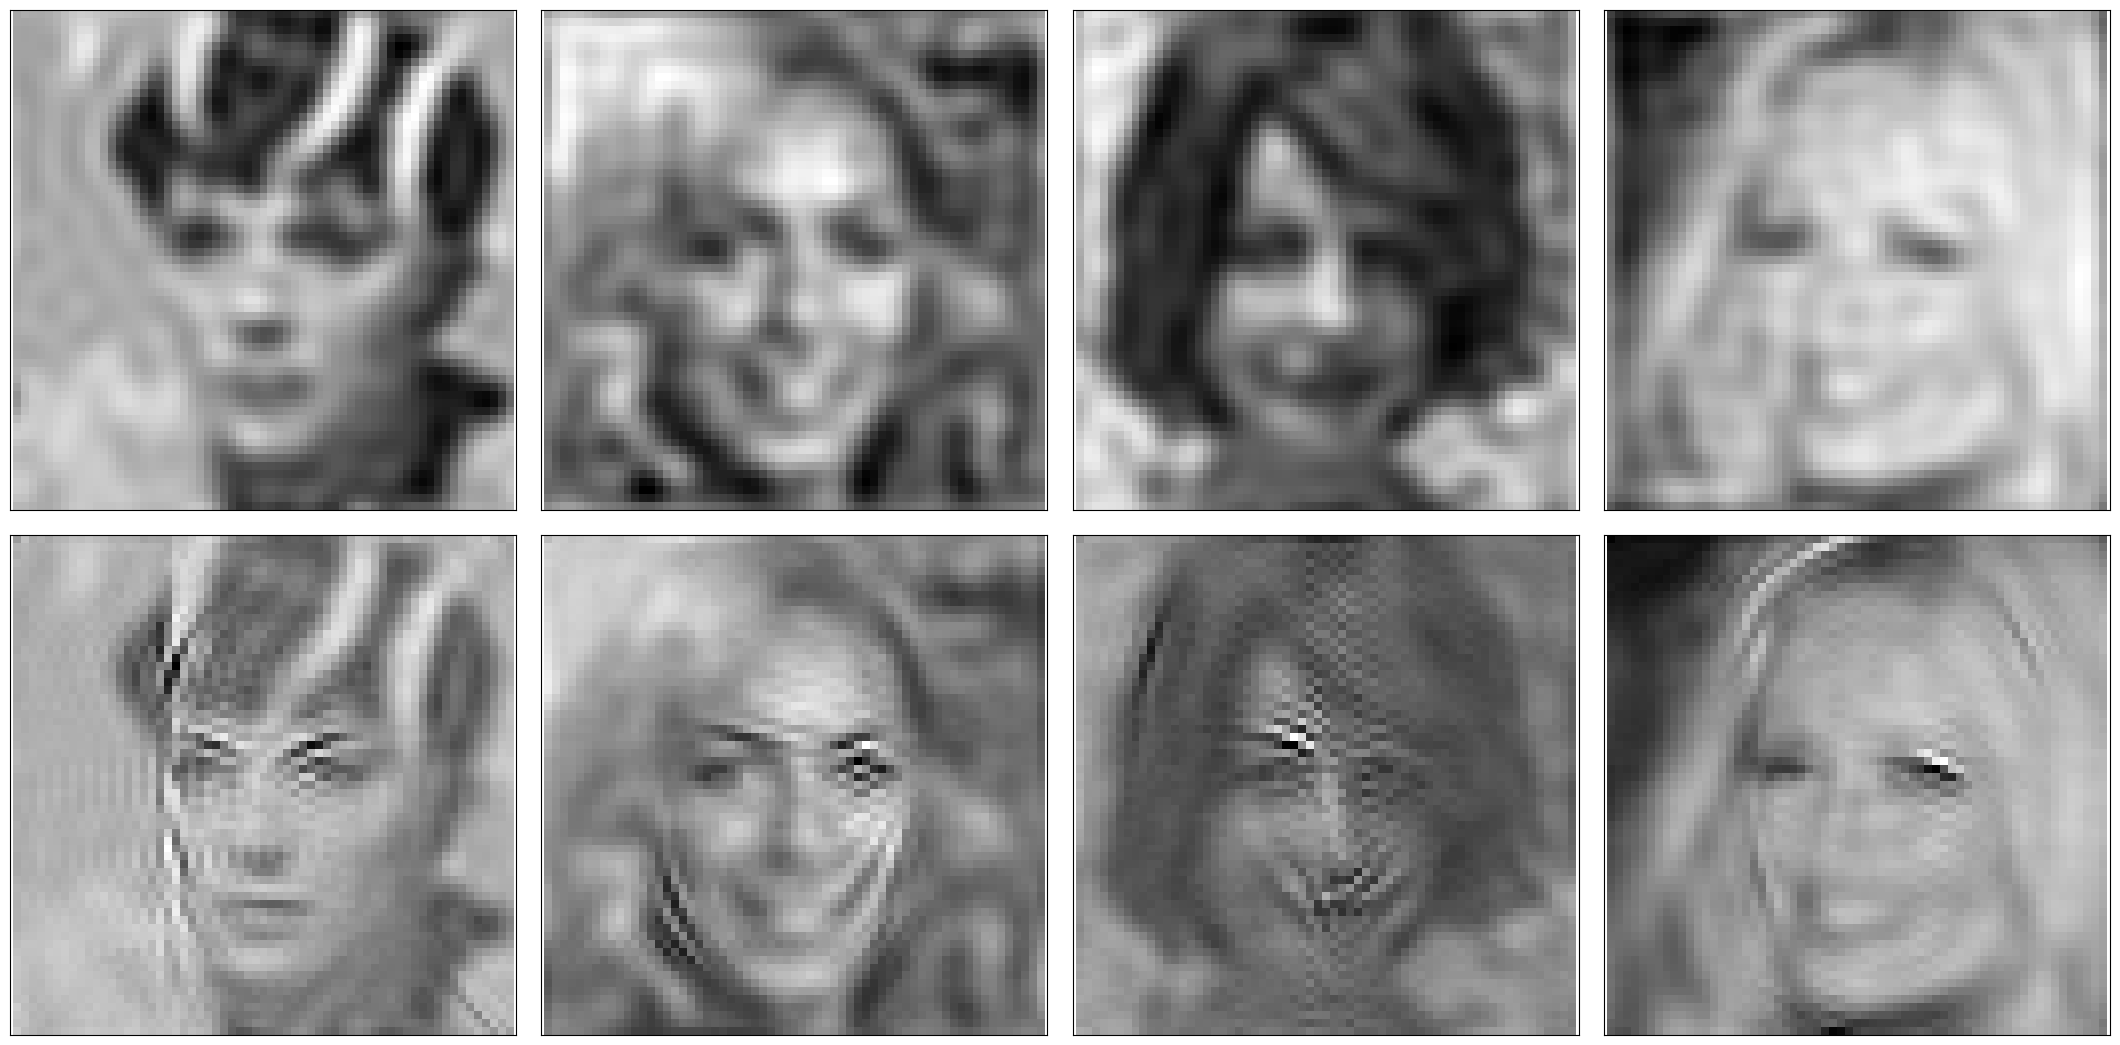

torch.Size([2016, 2])


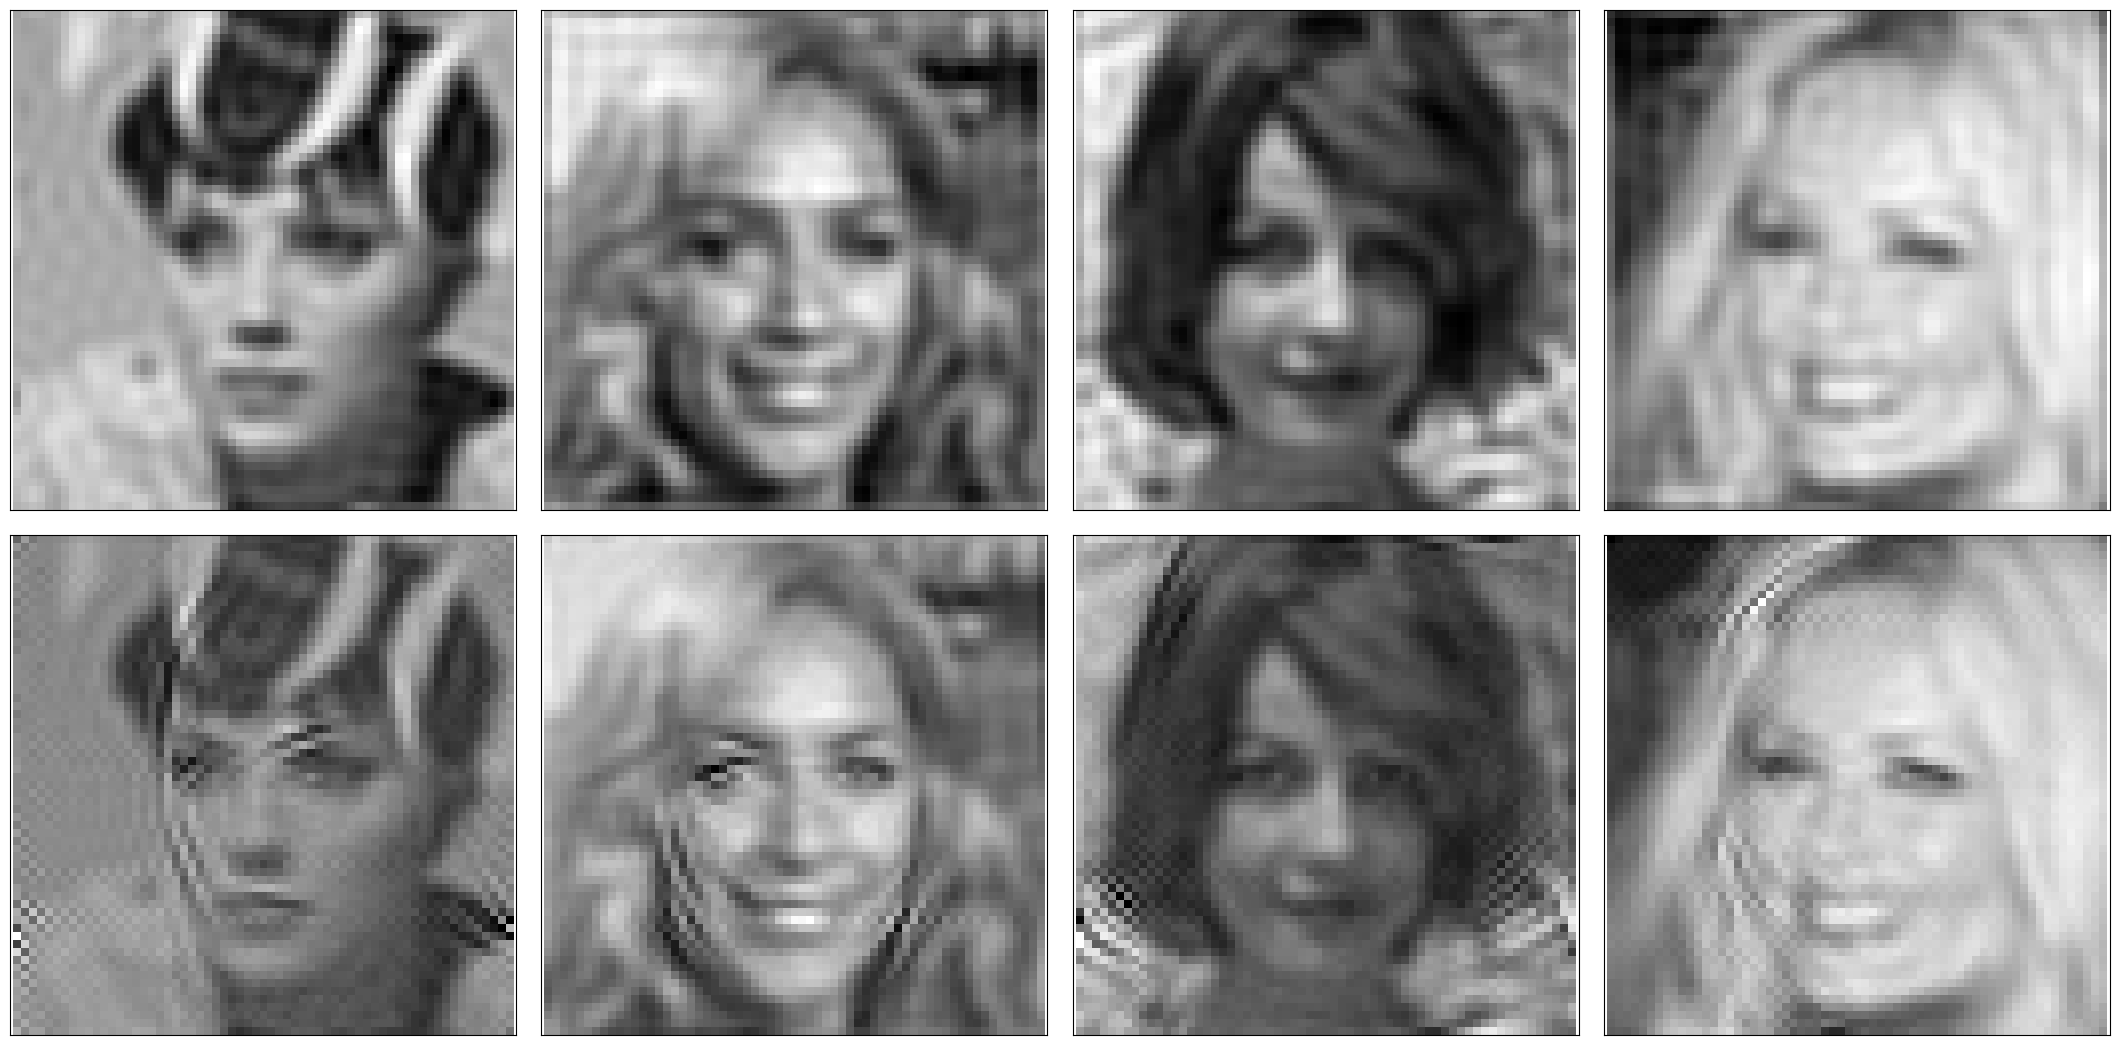

In [2]:

def predict_one_test_batch(num_images = 3,num_shells = model.shells):

    x, y = np.meshgrid(
                range(model.dft_shape[1]),
                range(-model.dft_shape[0] // 2, model.dft_shape[0] // 2 + 1))
    radii = np.roll(np.sqrt(x**2 + y**2, dtype=np.float32),model.dft_shape[0] // 2 + 1, 0)

    input_seq_len = np.sum(np.round(radii) < num_shells)
    
    # print(f"Input Sequence Length: {input_seq_len}")
    
    for fc, (mag_min, mag_max) in dm.test_dataloader():
        break
    n_imgs  = min(num_images,fc.shape[0])
    fc = fc.to('cuda')
    mag_min = mag_min.to('cuda')
    mag_min = mag_min[:n_imgs].to('cuda')
    mag_max = mag_max.to('cuda')
    mag_max = mag_max[:n_imgs].to('cuda')
    x_input = fc[:n_imgs,model.dst_flatten_order][:, :input_seq_len]

    gt = fc[:n_imgs, model.dst_flatten_order]
    s = time.time()
    with torch.no_grad():
        pred = model.sres.forward_inference(x_input,max_seq_length=gt.shape[1])
    e = time.time()
    t = e-s
    # pred[:,:,1] = gt[:,:,1]
    # pred = torch.zeros_like(gt)
   
    lowres = torch.zeros_like(pred)
    lowres += x_input.min()
    lowres[:, :input_seq_len] = x_input

    pred_img = model.convert2img(fc=pred, mag_min=mag_min, mag_max=mag_max)
    lowres_img = model.convert2img(fc=lowres, mag_min=mag_min, mag_max=mag_max)
    gt_img = model.convert2img(fc=gt, mag_min=mag_min, mag_max=mag_max)

    lowres_img = denormalize(lowres_img,dm.mean,dm.std)
    pred_img = denormalize(pred_img,dm.mean,dm.std)
    gt_img = denormalize(gt_img,dm.mean,dm.std)



    lowres_psnr = PSNR(gt_img,lowres_img)
    pred_psnr = PSNR(gt_img,pred_img)
    gt_psnr = PSNR(gt_img,gt_img)
    return pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, num_images, input_seq_len,t

def plot_images(pred_img, gt_img, lowres_img, l, shells):
    for i in [pred_img, lowres_img, gt_img]:
        i.cpu().detach().numpy()
    fig2 = plt.figure(figsize=(21, 10.25)) 
    gs = gridspec.GridSpec(3, 2*4-1, height_ratios=[1, 0.05, 1], width_ratios=[1,0.05,1,0.05,1,0.05,1])
    for s,i in enumerate(l):
        # Adjust figure size for column layout
        sample = s
         # GridSpec for column layout

        ax0 = plt.subplot(gs[0,i])
        ax2 = plt.subplot(gs[2,i])
        # ax4 = plt.subplot(gs[4])

        plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)

        ax0.xaxis.set_major_locator(plt.NullLocator())
        ax0.yaxis.set_major_locator(plt.NullLocator())
        ax0.imshow(lowres_img[sample].cpu(), cmap='gray')
        ax0.axis('equal')

        ax2.xaxis.set_major_locator(plt.NullLocator())
        ax2.yaxis.set_major_locator(plt.NullLocator())
        ax2.imshow(pred_img[sample].cpu(), cmap='gray')
        ax2.axis('equal')

        # ax4.xaxis.set_major_locator(plt.NullLocator())
        # ax4.yaxis.set_major_locator(plt.NullLocator())
        # ax4.imshow(gt_img[sample].cpu(), cmap='gray')
        # ax4.axis('equal')

    plt.savefig(f'/group/jug/Aman/Inference/New_1/{shells}.png')
    plt.show()
shells = [4,8,12,16]
# shells = [2,4,6,8]
for shell in shells:
    pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, no_of_images,input_seq_len, t= predict_one_test_batch(num_images = 12,num_shells=shell)
    plot_images(pred_img, gt_img, lowres_img, shells = shell, l = [0,2,4,6])
    
# b = np.arange(1,32,2)
# for i in b:
#     pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, no_of_images,input_seq_len = predict_one_test_batch(num_images = 6,num_shells=i)
#     plot_images(pred_img, gt_img, lowres_img, lowres_psnr, pred_psnr, gt_psnr, no_of_images,input_seq_len, shells = i)

# from PIL import Image
# from natsort import natsorted
# import glob

# # Create the frames
# frames = []
# imgs = glob.glob("/home/aman.kukde/Projects/FourierImageTransformer/aman/img_2/*.jpg")
# for i in natsorted(imgs):
#     new_frame = Image.open(i)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save('png_to_gif_2.gif', format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=300, loop=0)

In [13]:
# #Mamba
# Input Sequence Length: 22
# torch.Size([378, 2])
# 2.343625068664551
# Input Sequence Length: 54
# torch.Size([378, 2])
# 1.8382294178009033
# Input Sequence Length: 96
# torch.Size([378, 2])
# 1.6017119884490967
# Input Sequence Length: 156
# torch.Size([378, 2])
# 1.3361268043518066

# #fast
# Input Sequence Length: 22
# torch.Size([378, 2])
# 2.9275031089782715
# Input Sequence Length: 54
# torch.Size([378, 2])
# 2.5919904708862305
# Input Sequence Length: 96
# torch.Size([378, 2])
# 2.364957332611084
# Input Sequence Length: 156
# torch.Size([378, 2])
# 2.05022931098938

Text(0.5, 1.0, 'MNIST: Inference Time vs Input Sequence Length')

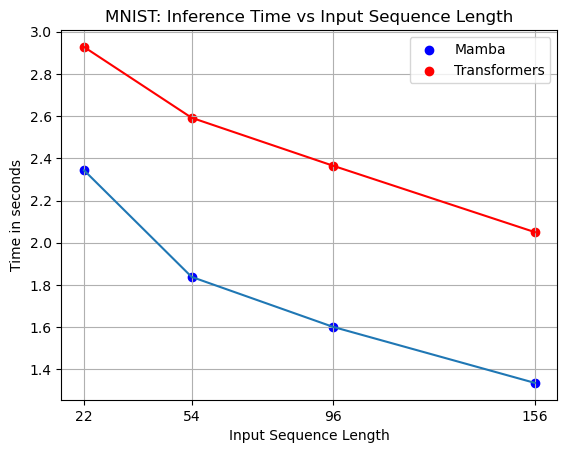

In [33]:
plt.plot([22,54,96,156],[2.343625068664551,1.8382294178009033,1.6017119884490967,1.3361268043518066])
plt.plot([22,54,96,156],[2.9275031089782715,2.5919904708862305,2.364957332611084,2.05022931098938], c = 'r')
plt.scatter([22,54,96,156],[2.343625068664551,1.8382294178009033,1.6017119884490967,1.3361268043518066],c='b',label = 'Mamba')
plt.scatter([22,54,96,156],[2.9275031089782715,2.5919904708862305,2.364957332611084,2.05022931098938],c='r',label = 'Transformers')
plt.xticks([22,54,96,156])
plt.xlabel('Input Sequence Length')
plt.ylabel('Time in seconds')
plt.grid()
plt.legend()
plt.title('MNIST: Inference Time vs Input Sequence Length')

In [14]:
# # CelebA
# #mamba
# Input Sequence Length: 222
# torch.Size([2016, 2])
# 14.560665607452393
# Input Sequence Length: 302
# torch.Size([2016, 2])
# 13.940002918243408
# Input Sequence Length: 390
# torch.Size([2016, 2])
# 13.509599447250366

# #fast
# Input Sequence Length: 222
# torch.Size([2016, 2])
# 56.72006702423096
# Input Sequence Length: 302
# torch.Size([2016, 2])
# 55.266911029815674
# Input Sequence Length: 390
# torch.Size([2016, 2])
# 54.79184436798096

Text(0.5, 1.0, 'CelebA: Inference Time vs Input Sequence Length')

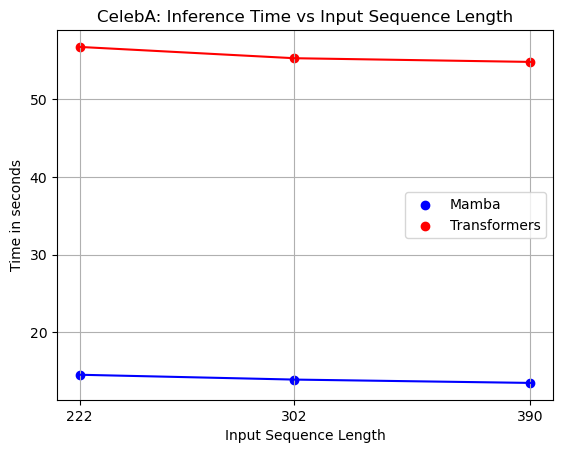

In [34]:
plt.plot([222,302,390],[14.560665607452393,13.940002918243408,13.509599447250366], c = 'b')
plt.scatter([222,302,390],[14.560665607452393,13.940002918243408,13.509599447250366], c = 'b', label = 'Mamba')
plt.plot([222,302,390],[56.72006702423096,55.266911029815674,54.79184436798096], c = 'r')
plt.scatter([222,302,390],[56.72006702423096,55.266911029815674,54.79184436798096], c = 'r', label = 'Transformers')
plt.xticks([222,302,390])
plt.xlabel('Input Sequence Length')
plt.ylabel('Time in seconds')
plt.grid()
plt.legend()
plt.title('CelebA: Inference Time vs Input Sequence Length')